# Tarea 2 MA-5701

Integrantes:

    - Sebastian Lopez
    - Kurt Walsen
    - Francisco Vásquez

# Previos

## Importación de Librerías

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tick
#import gurobipy as gb
import scipy.optimize as opti

from sklearn.metrics import mean_squared_error

## Parámetros Generales

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)

# Parámetros para gráficos
plt.style.use('seaborn')

plt.rcParams.update({'font.size': 25})      
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)  
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.titlesize'] = 25
plt.rcParams["figure.figsize"] = (15,6)

# Trabajo de Datos

## Importación

In [4]:
df = pd.read_csv('data/data_modificada.csv')

## Trabajo previo

In [5]:
df.head()

,Fecha,Dia,Casos Totales,Recuperados,Fallecidos,Removidos
0,3/3/2020,1,1,0,0,0
1,3/4/2020,2,3,0,0,0
2,3/5/2020,3,4,0,0,0
3,3/6/2020,4,5,0,0,0
4,3/7/2020,5,7,0,0,0


In [6]:
df.Fecha = pd.to_datetime(df.Fecha)
df = df.sort_values(by = 'Fecha')

# Visualizaciones

In [7]:
def plot_columna(columna):
    data = df.set_index('Fecha')[columna]
    
    fig, ax = plt.subplots()
    
    grafico = data.plot(kind = 'line', ax = ax,
                       style = '.-', linewidth = 2,
                       ms = 10)
    
    plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Fecha')
    
    plt.title('Cantidad de {} por Fecha'.format(columna))
    plt.tight_layout()
    plt.savefig('graficos/graf_cantidad_{}_fecha.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)
    plt.show()

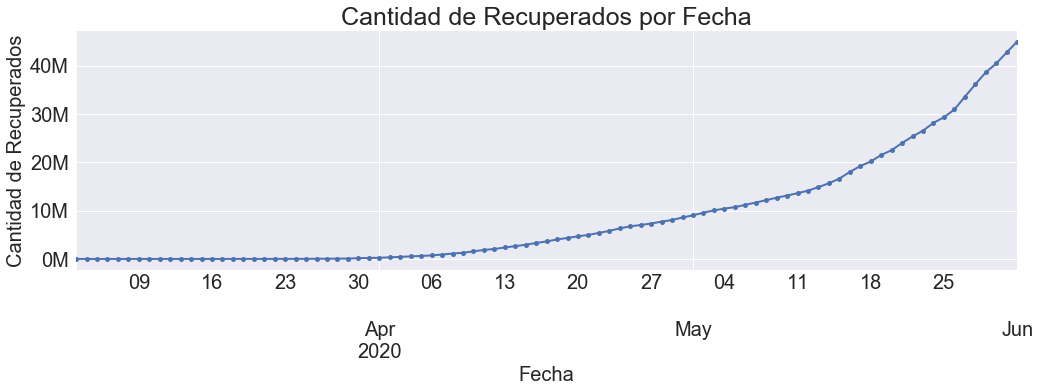

In [8]:
plot_columna('Recuperados')

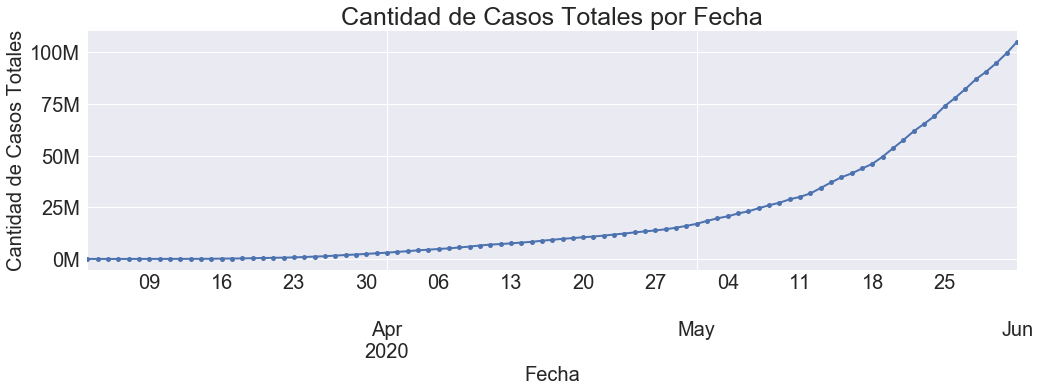

In [9]:
plot_columna('Casos Totales')

# Modelo

## Modelo Infectados General

In [122]:
def func_to_optimize_infectados(params):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    val = 0
    
    for dia, n_infectados in enumerate(df['Casos Totales']):
        logit = (alpha)/(1 + beta * np.exp(-dia / sigma))
        val += np.power(n_infectados - logit, 2)
    
    return val

In [123]:
bnds_infectados = ((0, None), (0, None), (0, None))

x0_infectados_general = [1000000., 200., 10.]

In [124]:
mod_infectados_general = opti.minimize(fun = func_to_optimize_infectados,
                                       x0 = x0_infectados_general,
                                       bounds = bnds_infectados)

## Modelo Infectados Máximo 250M

In [190]:
#constraints_infectados = (
#                             {'type': 'ineq',
#                            'fun': lambda param: param[0] - 250000 }
#                          {'type': 'eq',
#                           'fun': lambda param: param[0] - 250000}
#                         )

#x0_infectados_cota = [250000., 300., 20.]
x0_infectados_cota = [250000., 300., 18.]
bnds_infectados_cota = ((0, 250000), (0, None), (0, None))
mod_infectados_cota = opti.minimize(fun = func_to_optimize_infectados,
                                    x0 = x0_infectados_cota,
                                    bounds = bnds_infectados_cota)

## Modelo Fallecidos General

In [70]:
def func_to_optimize_fallecidos(params):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    val = 0
    
    for dia, n_infectados in enumerate(df['Fallecidos']):
        logit = (alpha)/(1 + beta * np.exp(-dia / sigma))
        val += np.power(n_infectados - logit, 2)
    
    return val

In [71]:
constraints_fallecidos = (#{'type': 'ineq',
               #'fun': lambda param: param[0]... >= 0},
              {'type': 'eq',
               'fun': lambda param: param[0] - 250000})
        
bnds_fallecidos = ((0, 18000000), (0, None), (0, None))

x0_fallecidos_general = [1500., 50., 20.]

In [72]:
mod_fallecidos_general = opti.minimize(fun = func_to_optimize_fallecidos,
                                       x0 = x0_fallecidos_general,
                                       bounds = bnds_fallecidos)

# Resultados

## Auxiliar Predicciones

In [125]:
def predicciones(params, vec_dias):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    fun = lambda t: (alpha)/(1 + beta * np.exp(-t / sigma))
    
    return list(map(fun, vec_dias))

In [126]:
def plot_diferencias(columna, predicciones, extra = False):
    dia = df['Dia']
    original = df[columna]
    
    fig, ax = plt.subplots()
    
    grafico_real = plt.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                              c = 'green')
    
    grafico_predicciones = plt.plot(dia, predicciones, label = 'Predicción', c = 'royalblue')
    
    if columna == 'Fallecidos':
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Día')
    
    plt.legend(loc=2)
    plt.tight_layout()
    
    if extra:
        plt.title('Predicción de {} por día, Máximo 250M'.format(columna))
        plt.savefig('graficos/graf_prediccion_{}_dia_250M.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)      
    else:
        plt.title('Predicción de {} por día'.format(columna))
        plt.savefig('graficos/graf_prediccion_{}_dia.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)
    plt.show()

In [127]:
def pred_largo_plazo(params, dias, columna, extra = False):
    # Generar predicciones
    pred = predicciones(params, range(1,dias+1))
    
    dia = df['Dia']
    original = df[columna]
    
    fig, ax = plt.subplots()
    
    grafico_real = plt.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                              c = 'green')
    
    
    grafico_predicciones = plt.plot(range(1, dias+1), pred, label = 'Predicción', c = 'royalblue')
    
    
    if columna == 'Fallecidos':
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Día')
    
    plt.legend(loc=2)
    plt.tight_layout()
    
    if extra:
        plt.title('Predicción de {} a {} dias, Máximo 250M'.format(columna, dias))
        plt.savefig('graficos/graf_prediccion_{}_a_{}_dias_250M.pdf'.format(columna.replace(' ',''), dias),
                   format = 'pdf',
                   dpi = 600)
    else:
        plt.title('Predicción de {} a {} dias'.format(columna, dias))
        plt.savefig('graficos/graf_prediccion_{}_a_{}_dias.pdf'.format(columna.replace(' ',''), dias),
                   format = 'pdf',
                   dpi = 600)
    plt.show()

## Predicciones Infectados General

In [129]:
print('Parámetros encontrados:\n Alpha: {} \n Beta: {} \n Sigma: {}'.format(mod_infectados_general.x[0],
                                                                            mod_infectados_general.x[1],
                                                                            mod_infectados_general.x[2]))

Parámetros encontrados:
 Alpha: 999999.4070542057 
 Beta: 2088.923087487889 
 Sigma: 16.312785404640493


In [130]:
# Prediccion con los parámetros obtenidos de mod_infectados
total_pred = predicciones(mod_infectados_general.x, df['Dia'])

In [133]:
rmse_infectados = np.sqrt(mean_squared_error(df['Casos Totales'], total_pred))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_infectados))

El RMSE obtenido con las predicciones es de
 RMSE: 2255.2969692746674


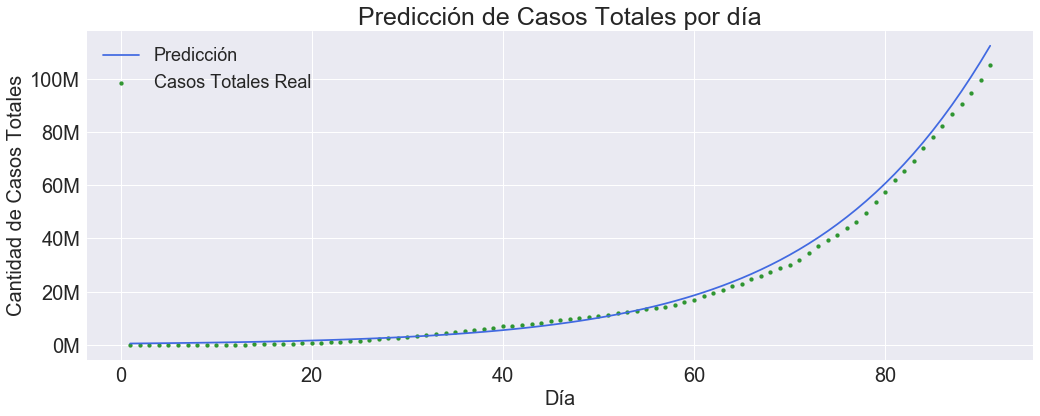

In [132]:
plot_diferencias('Casos Totales', total_pred)

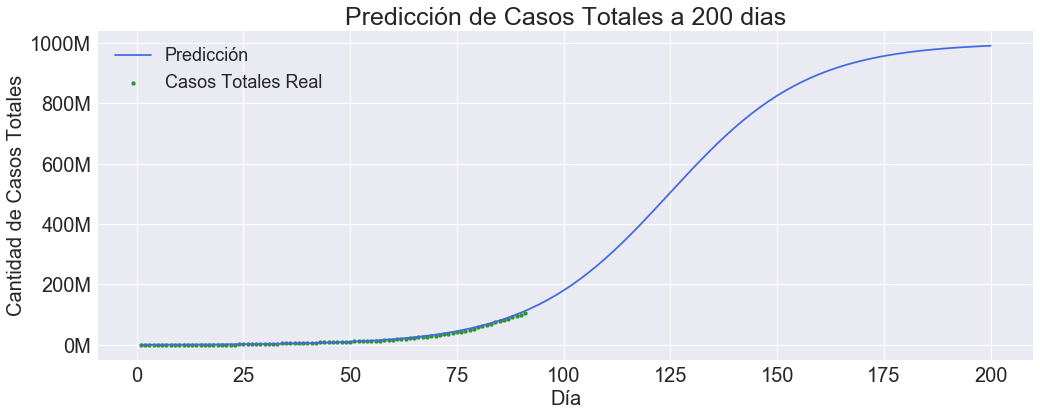

In [134]:
pred_largo_plazo(mod_infectados_general.x, 200, 'Casos Totales')

## Predicciones Infectados Cota

In [196]:
print('Parámetros encontrados:\n Alpha: {} \n Beta: {} \n Sigma: {}'.format(mod_infectados_cota.x[0],
                                                                            mod_infectados_cota.x[1],
                                                                            mod_infectados_cota.x[2]))

Parámetros encontrados:
 Alpha: 249997.5734659315 
 Beta: 1031.081217880581 
 Sigma: 13.707217714164392


In [197]:
# Prediccion con los parámetros obtenidos de mod_infectados
total_pred_cota = predicciones(mod_infectados_cota.x, df['Dia'])

In [198]:
rmse_infectados_cota = np.sqrt(mean_squared_error(df['Casos Totales'], total_pred_cota))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_infectados_cota))

El RMSE obtenido con las predicciones es de
 RMSE: 2466.2052282204586


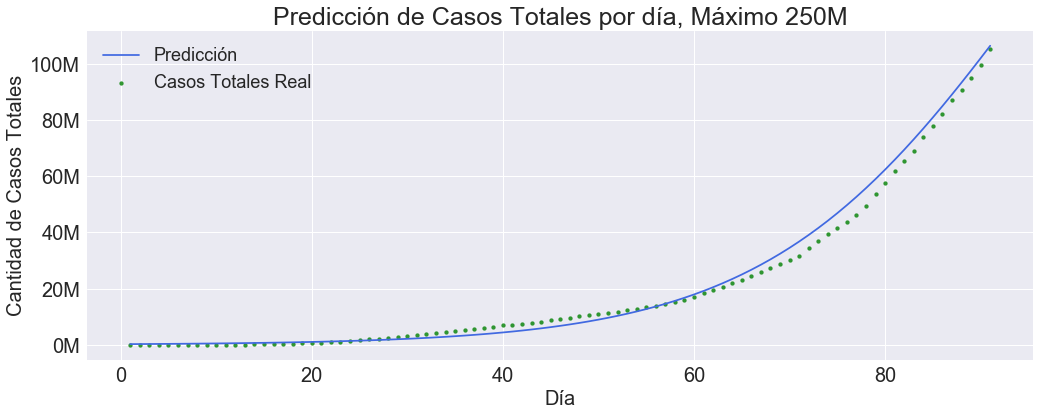

In [199]:
plot_diferencias('Casos Totales', total_pred_cota, extra = True)

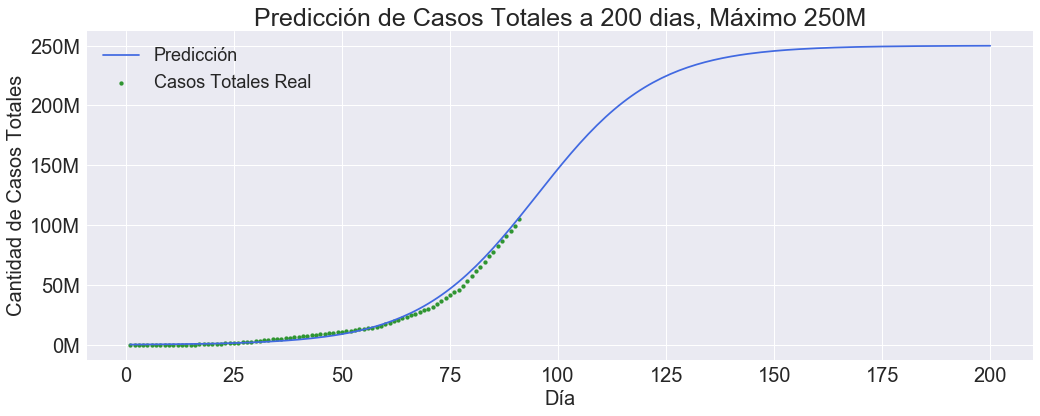

In [200]:
pred_largo_plazo(mod_infectados_cota.x, 200, 'Casos Totales', extra = True)

## Predicciones Fallecidos

In [55]:
print('Parámetros encontrados:\n Alpha: {} \n Beta: {} \n Sigma: {}'.format(mod_fallecidos_general.x[0],
                                                                            mod_fallecidos_general.x[1],
                                                                            mod_fallecidos_general.x[2]))

Parámetros encontrados:
 Alpha: 129776.64681273549 
 Beta: 16296.053220252557 
 Sigma: 18.238092533842213


In [56]:
# Prediccion con los parámetros obtenidos de mod_fallecidos
fallecidos_pred = predicciones(mod_fallecidos_general.x, df['Dia'])

In [57]:
rmse_fallecidos = np.sqrt(mean_squared_error(df['Fallecidos'], fallecidos_pred))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_fallecidos))

El RMSE obtenido con las predicciones es de
 RMSE: 30.48951884021558


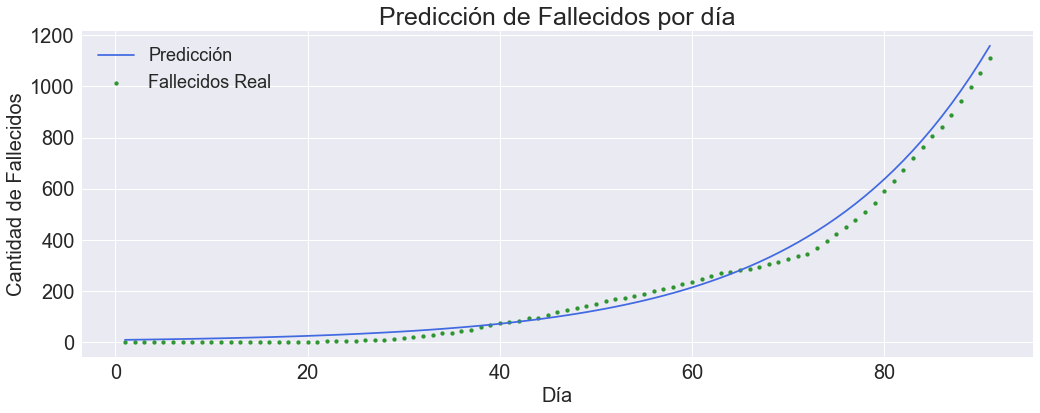

In [58]:
plot_diferencias('Fallecidos', fallecidos_pred)

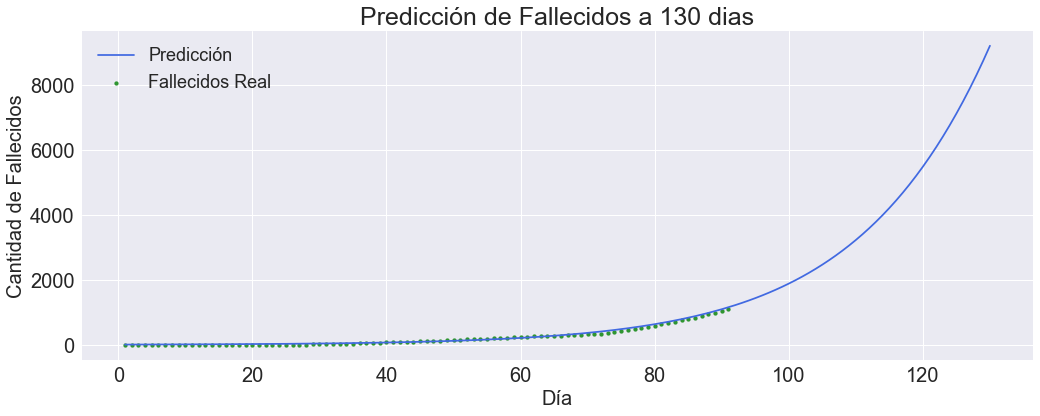

In [59]:
pred_largo_plazo(mod_fallecidos_general.x, 130, 'Fallecidos')